In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
# from transformers import AutoImageProcessor, ResNetForImageClassification,ResNetConfig
import torch
from abc import ABC,abstractmethod

###DATASET PREP###

In [4]:
projectPath = r"C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\testIm"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)
        
# dir structure: projectPath/label/image

In [6]:
for idx,x in enumerate(dirList):
    print(idx)
    print(f"{x}: {len(os.listdir(f'{projectPath}/{x}'))}")

0
normal: 57
1
osteopenia: 240
2
osteoporosis: 73


In [7]:
from PIL import Image
imageSizes = {}
for x in pathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

{'(244, 244)': 370}

In [8]:
import torchvision
import torch
import torchvision.transforms.functional as vF

class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None, std = False, mean = False): #mean on if mean needs to be scaled, same goes for std
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform
        self.std = std
        self.mean = mean

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx)->tuple[Image.Image,int]:
        image = Image.open(self.itemsPath[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)  
        
        image.to(device = torch.device('cuda'))

        return image, self.labels[idx], self.itemsPath[idx]          
    
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            # torchvision.transforms.Resize((256,256)),
                                            # torchvision.transforms.CenterCrop((224,224)),
                                            torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                                            ])                           

In [9]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

osteoDataset = OsteoTorchDataset(pathList,labelList,transform,std=False,mean=False)      
train,val = torch.utils.data.random_split(osteoDataset,[0.8,0.2])#MAY BUG
trainLabels = [y for x,y,z in train]
unique_elements, counts = torch.unique(torch.tensor(trainLabels), return_counts=True)
sampleWeights = 1. / counts.float() #I HAVE NO IDEA WHY THIS WORKS BUT IT DOES
# MORAL OF THE STORY: FOLLOW THE FUCKING TUTORIAL DONT TRY CHANGING SHIT ON YOUR OWN ***EVEN IF THE DOCUMENTATION SAYS YOU SHOULD***
trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabels],num_samples=len(train),replacement=True)

trainLoader = DataLoader(train, batch_size = 8,shuffle=False,num_workers=0,sampler=trainSampler)
valLoader = DataLoader(val, batch_size = 8,shuffle=False,num_workers=0)

unique_elements, counts = torch.unique(torch.cat([x for y,x,z in trainLoader]), return_counts=True)#delet this
counts

tensor([ 98, 101,  97])

In [10]:
unique_elements, counts = torch.unique(torch.cat([x for y,x,z in valLoader]), return_counts=True)#delet this
counts

tensor([12, 48, 14])

In [13]:
temp = next(iter(trainLoader))
temp[0][0].max()
index = -1

tensor(1.)

255
C:\Users\assaw\Documents\c_stuff\Python\machine learning\ISAIConference\testIm/osteoporosis/OS350.jpg


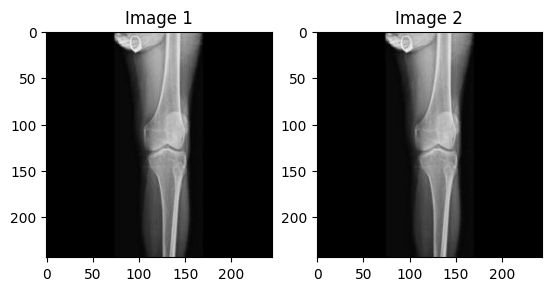

In [15]:
# temp[0][0].min()
import matplotlib.pyplot as plt
index += 1
# print(temp[1][index],temp[2][index])
print((temp[0][index].numpy()*255).max().astype(np.uint8))

fig, axs = plt.subplots(1, 2)

print(str(temp[2][index]))
# Plot the first image
axs[0].imshow(((temp[0][index]+1)/2).permute(1, 2, 0))
axs[0].set_title('Image 1')

# Plot the second image
axs[1].imshow(Image.open(temp[2][index]).convert('RGB'))
axs[1].set_title('Image 2')

plt.show()

In [16]:
# import models here
from resnetModel import ResNet50
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
import cv2
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns
from abc import ABC

#FIXME identify bottleneck
#FIXME clean up my fucking code ffs its so UGLY

class ExperimentModel(L.LightningModule,ABC):

    existingModels = []

    def __init__(self) -> None:
        ExperimentModel.existingModels.append(self)
        super().__init__()

        #init the models here in a subclass

        self.num_class = 3
        self.classWeight = torch.tensor([0.204, 0.052, 0.175],device='cuda')

        self.valLog = []
        self.epoch = []
        self.valPreds = []
        self.valLabels = []
        self.valScore = []

        self.bestValPreds = [[]]
        self.bestValLabels = [[]]
        self.bestValScore = []

        self.dump = []

    @abstractmethod
    def forward():
        pass
        
    # def forward(self,input):
    #     out = self.model(input)
    #     return out
        
    def training_step(self,batch):
        data,label,path = batch
        output = self(data)
        self.dump.append([path,label])
        loss = F.cross_entropy(output,label,weight=self.classWeight)
        # print(loss)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", multiclass_accuracy(output.argmax(1),label,num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        data,label,path = batch
        output = self(data)

        preds = output.argmax(1)
        loss = F.cross_entropy(output,label)
        self.valLabels.append(label)
        self.valPreds.append(preds)
        self.valScore.append(multiclass_f1_score(preds,label,num_classes=self.num_class,average = 'macro'))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_F1", multiclass_f1_score(preds,label,num_classes=self.num_class,average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", multiclass_accuracy(preds,label,num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    
    # def on_validation_epoch_end(self) -> None:
    #     if len(self.valScore) == 2:
    #         return None
        
    #     accuracy = torch.stack(self.valScore).mean()
    #     self.bestValScore.append(accuracy)
    #     self.bestValPreds.append(torch.cat(self.valPreds))
    #     self.bestValLabels.append(torch.cat(self.valLabels))
    #     print(f"preds: {torch.cat(self.valPreds)}\n labels: {torch.cat(self.valLabels)}")
    #     # self.log("val_acc_F1", multiclass_f1_score(torch.cat(self.valPreds),torch.cat(self.valLabels),num_classes=self.num_class,average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True)
       
    #     # print(f"\n Validation accuracy: {accuracy}")
    #     # print(f"bestValScore: {self.bestValScore}")
    #     self.valPreds = []
    #     self.valLabels = []
    #     self.valScore = []

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

    def predict_step(self, batch):
        data,label = batch
        return self(data.float())

In [19]:
class GradCamTrack(ExperimentModel):
    def __init__(self,vgg:torchvision.models.vgg.VGG) -> None:
        super().__init__()
        self.features_conv = vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = vgg.classifier
        self.classifier[6] = torch.nn.Linear(4096,3)

        self.hookedImage = []
        
        # placeholder for the gradients
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)
        
    def forward(self,inTensor):
        x = self.features_conv(inTensor)
        
        # # register the hook
        if x.requires_grad:
            hook = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.flatten(1,-1)
        x = self.classifier(x)
        return x
     
    def visualize(self,dataloader:torch.utils.data.dataloader.DataLoader): #TODO FIX THIS for generalization
        out,path = self.CAM(dataloader)
        for x in range(len(out)):
            self.visualizeAndWrite(out[x],path[x],666)
    
    def CAM(self,dataloader:torch.utils.data.dataloader.DataLoader):
        self.eval()
        img,label,path = next(iter(dataloader))
        img = img.to(device = torch.device('cuda'))
        heatmapList = []
        for i in range(len(img)):
            print(torch.unsqueeze(img[i],0).shape)
            pred = self(torch.unsqueeze(img[i],0))
            # get the gradient of the output with respect to the parameters of the model
            print(pred.shape)
            pred[:, label[i].item()].backward()

            # pull the gradients out of the model
            gradients = self.get_activations_gradient()

            # pool the gradients across the channels
            pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

            # get the activations of the last convolutional layer
            activations = self.get_activations(torch.unsqueeze(img[i],0)).detach() # DONT forget to apply image changes here too
            print(activations.shape)
            # weight the channels by corresponding gradients
            for j in range(512):
                activations[:, j, :, :] *= pooled_gradients[j]
                
            # average the channels of the activations
            heatmap = torch.mean(activations, dim=1).squeeze()

            # relu on top of the heatmap
            # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
            heatmap = np.maximum(heatmap.cpu(), 0)

            # normalize the heatmap
            heatmap /= torch.max(heatmap)

            # draw the heatmap
            heatmapList.append(heatmap)

        return heatmapList,path

    def visualizeAndWrite(self,out:torch.tensor,path:str,epoch=False):
        if not epoch:
            epoch = self.current_epoch
            
        img = cv2.imread(path)
        heatmap = cv2.resize(out.numpy(), (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.4 + img
        cv2.imwrite(rf'./visualizations/gradCam/{epoch}_{path.split(r"/")[-1]}', superimposed_img)

In [71]:
vgg19 = VGGModel(torchvision.models.vgg19(pretrained=True))

C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
ExperimentModel.existingModels[0].__class__.__name__

In [ ]:
ExperimentModel.existingModels[0]

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
for x in ExperimentModel.existingModels:
    print(x)
    gc.collect()
    torch.cuda.empty_cache()
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',  # Metric to monitor
    #     patience=5000,          # Number of epochs with no improvement after which training will be stopped
    #     verbose=False,        # Verbosity mode
    #     mode='min'           # Mode can be 'min', 'max', or 'auto'
    # )

    logger = TensorBoardLogger("tb_logs", name=f"{x.__class__.__name__}")
    

    trainer = L.Trainer(max_epochs = 75,accelerator='gpu', devices='auto', precision='16-mixed',logger=logger)
    trainer.fit(model=x,train_dataloaders=trainLoader,val_dataloaders=valLoader)


In [104]:
model = VGGModel.load_from_checkpoint(r'tb_logs\VGGModel\version_4\checkpoints\epoch=25-step=962.ckpt',vgg = torchvision.models.vgg19(pretrained=False))

C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the 

In [52]:
x = next(iter(valLoader))
model(x[0].to('cuda')).argmax(1)

tensor([1, 1, 1, 1, 1, 0, 2, 2], device='cuda:0')

In [68]:
x[1][0].item()

1

In [20]:
torch.cuda.empty_cache()
model = VGGModel.load_from_checkpoint(r'tb_logs\VGGModel\version_4\checkpoints\epoch=25-step=962.ckpt',vgg = torchvision.models.vgg19(pretrained=False))

model.visualize(valLoader)

C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the 

torch.Size([1, 3, 244, 244])
torch.Size([1, 3])
torch.Size([1, 512, 15, 15])
torch.Size([1, 3, 244, 244])
torch.Size([1, 3])
torch.Size([1, 512, 15, 15])
torch.Size([1, 3, 244, 244])
torch.Size([1, 3])
torch.Size([1, 512, 15, 15])
torch.Size([1, 3, 244, 244])
torch.Size([1, 3])
torch.Size([1, 512, 15, 15])
torch.Size([1, 3, 244, 244])
torch.Size([1, 3])
torch.Size([1, 512, 15, 15])
torch.Size([1, 3, 244, 244])
torch.Size([1, 3])
torch.Size([1, 512, 15, 15])
torch.Size([1, 3, 244, 244])
torch.Size([1, 3])
torch.Size([1, 512, 15, 15])
torch.Size([1, 3, 244, 244])
torch.Size([1, 3])
torch.Size([1, 512, 15, 15])


In [99]:
out[1][0].split('/')[-1]

'OP270.jpg'

In [47]:
ExperimentModel.existingModels[0].valPreds

[tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'),
 tensor([2, 2, 2, 2, 0, 2, 2, 2], device='cuda:0'),
 tensor([2, 0, 2, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([2, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([2, 0, 0, 2, 0, 0, 2, 0], device='cuda:0'),
 tensor([0, 0, 2, 2, 0, 0, 0, 2], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 2, 0, 0], device='cuda:0'),
 tensor([0, 2, 0, 0, 0, 0, 0, 2], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 2], device='cuda:0'),
 tensor([0, 0, 2, 2, 2, 0, 0, 0], device='cuda:0'),
 tensor([0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 2, 0, 0, 0, 2, 0, 0], device='cuda:0'),
 tensor([0, 2, 0, 0, 0, 0, 0, 2], device='cuda:0'),
 tensor([0, 2, 0, 0, 0, 0, 0, 2], device='cuda:0'),
 tensor([0, 0, 0, 2, 0, 0, 2, 2], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# [[y.argmax().item() for y in w] for w in x.bestValPreds]
# ([1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1,
#          1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
# [[y.argmax().item() for y in w] for w in x.bestValPreds]
preds = torch.tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2, 2, 1, 1,
        1, 1])
labels = torch.tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 2, 2, 1, 2, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 2, 2, 0, 1, 1, 2, 2, 1, 1, 0, 2,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1])
index = 50
cm = confusion_matrix(preds,labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# plt.plot(confusion_matrix([[y.argmax().item() for y in w] for w in x.bestValPreds][index],x.bestValLabels[1].cpu()))
print(classification_report(preds,labels))


In [ ]:
img,_,_ = next(iter(trainLoader))
x = model.features(img)

In [ ]:
x.flatten(1,-1).shape

In [ ]:
c = model.classifier(x.flatten(1,-1))

In [ ]:
torch.unsqueeze(img[0],0).shape

In [72]:
vgg19.eval()
img,lab,path = next(iter(trainLoader))
pred = vgg19(torch.unsqueeze(img[0],0))
print(pred)
# get the gradient of the output with respect to the parameters of the model
pred[:, 1].backward()

# pull the gradients out of the model
gradients = vgg19.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg19.get_activations(torch.unsqueeze(img[0],0)).detach()
print(activations.shape)

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

tensor([[ 0.4603, -0.0584,  0.0571]], grad_fn=<AddmmBackward0>)
torch.Size([1, 512, 15, 15])


In [93]:
import cv2
img = cv2.imread(out[1][0])
heatmap = cv2.resize(out[0][0].numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./test.jpg', superimposed_img)

True

In [94]:
out[1][0]

'C:\\Users\\assaw\\Documents\\c_stuff\\Python\\machine learning\\ISAIConference\\testIm/osteopenia/OP270.jpg'

In [ ]:
cv2.imwrite("img.jpg",superimposed_img)

In [ ]:
pred.argmax(dim=1)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.19.0', "vgg19",{"num_classes":3}, pretrained=True, )
model.classifier[6] = torch.nn.Linear(4096,3)
model

In [ ]:
model = vgg19

In [ ]:
import torch

import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
# Define the loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.204, 0.052, 0.175],device='cuda'))

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the device to GPU if available
device = torch.device("cuda")

# Move the model to the device
model = model.to(device)

# Set the model to training mode
model.train()

num_epochs = 15

accHistory = []
lossHistory = []
valAccHistory = []
valLabs = []
valPreds = []
print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = []
    
    # Iterate over the training dataset
    for inputs, labels, _ in trainLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs.float())
        predicted_labels = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)
        running_accuracy.append(accuracy)
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(trainLoader)}")
    print(F"Accuracy: {sum(running_accuracy)/len(running_accuracy)}")
    accHistory.append(sum(running_accuracy)/len(running_accuracy))
    lossHistory.append(running_loss / len(trainLoader))

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        
        runningValAccHistory = []
        runningValLabs = []
        runningValPreds = []
        for inputs, labels, _ in valLoader:

            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs.float())

            # Compute the loss
            loss = criterion(outputs, labels)

            # Compute the predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            # Compute the accuracy
            accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

            runningValAccHistory.append(accuracy)
            runningValLabs.append(labels)
            runningValPreds.append(predicted_labels)

        # print(f"Validation Loss: {loss.item()}")
        valPreds.append(runningValPreds)
        valLabs.append(runningValLabs)
        print(f"Validation Accuracy: {sum(runningValAccHistory)/len(valLoader)}")
        valAccHistory.append(sum(runningValAccHistory)/len(valLoader))

In [ ]:
import seaborn as sns
idx = 34
predsTest = torch.cat(valPreds[idx-1])
labelsTest = torch.cat(valLabs[idx-1])
print(valAccHistory[idx-1])
print(classification_report(predsTest.cpu(),labelsTest.cpu()))
cm= confusion_matrix(predsTest.cpu(),labelsTest.cpu(),normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
labelsTest

In [ ]:
plt.plot(valAccHistory)

In [ ]:
input , label, _ = next(iter(valLoader))
# Move the inputs and labels to the device
inputs = inputs.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(inputs)
predicted_labels = torch.argmax(outputs, dim=1)
print(predicted_labels)


In [ ]:
import seaborn as sns
import pandas as pd

# Create a dataframe with the data
df = pd.DataFrame({'Epoch': range(len(accHistory)), 'Accuracy': accHistory, 'Loss': lossHistory, 'Validation Accuracy': valAccHistory})

# Create the line plot
sns.relplot(data=df, x='Epoch', y='Accuracy', kind='line')
sns.relplot(data=df, x='Epoch', y='Loss', kind='line')
sns.relplot(data=df, x='Epoch', y='Validation Accuracy', kind='line')

In [ ]:
torch.save(model.state_dict(), "resnetClassic.pth")

In [ ]:
outputs = []
label = []
import gc
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
    for inputs, labels, _ in valLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        label = labels
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the predicted labels
        predicted_labels = torch.argmax(outputs, dim=1)

        # Compute the accuracy
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

In [ ]:
print(outputs.argmax(1))
print(label)